# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 10

## Student 1 
### Name : Yuan Tian
### ID : 5816971

## Student 2
### Name : Raphael Frühwirth
### ID : 5897297

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [2]:
# !pip install pyts

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import SymbolicAggregateApproximation #pip install pyts
import mmh3
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
from flexfringe import FlexFringe
import json
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import time
pd.options.mode.chained_assignment = None


path_flexfringe = "/home/raphael/Downloads/flexfringe-x64-linux"

## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [4]:
data = pd.read_csv("dataset_lab3/dataset_10/capture20110818.binetflow")
data_9 = pd.read_csv("dataset_lab3/dataset_9/capture20110817.binetflow")
data_11 = pd.read_csv("dataset_lab3/dataset_11/capture20110818-2.binetflow")
data_12 = pd.read_csv("dataset_lab3/dataset_12/capture20110819.binetflow")

In [5]:
data.head()

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established
3,2011/08/18 10:26:02.052163,1.187083,tcp,147.32.3.51,3130,->,147.32.84.46,10010,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
4,2011/08/18 10:26:52.226748,0.980571,tcp,88.212.37.169,3134,->,147.32.84.118,6881,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [6]:
infected_host_ip, infected_host_ip2  = data[data['Label'].str.contains("Botnet")]["SrcAddr"].unique()[:2]
regular_host_ip, regular_host_ip2  = data[data['Label'].str.contains("Normal")]["SrcAddr"].unique()[:2]

infected_data = data[data["SrcAddr"] == infected_host_ip]
non_infected = data[data["SrcAddr"] == regular_host_ip]

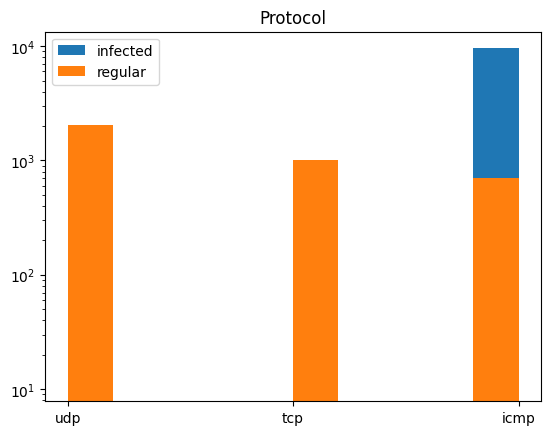

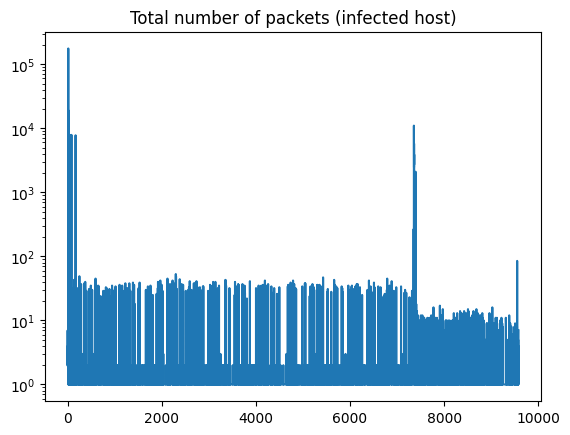

Text(0.5, 1.0, 'Total number of packets (regular)')

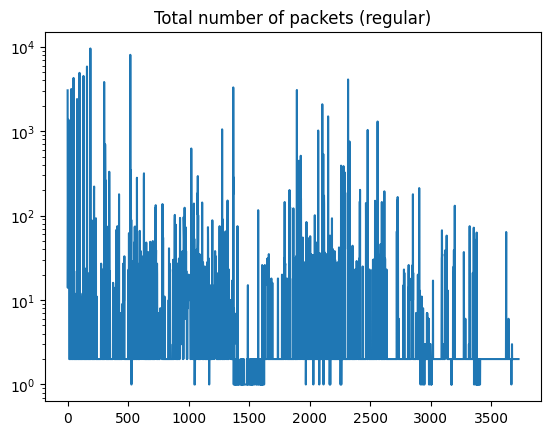

In [33]:
protocol = infected_data['Proto']
total_packets = infected_data['TotPkts']
protocol_normal = non_infected['Proto']
total_packets_normal = non_infected['TotPkts']

plt.hist(protocol, label='infected', log=True)
plt.hist(protocol_normal, label='regular', log=True)
plt.legend()
plt.title("Protocol")
plt.show()

plt.semilogy(range(len(total_packets)), total_packets, label='infected')
plt.title("Total number of packets (infected host)")

plt.show()
plt.semilogy(range(len(total_packets_normal)), total_packets_normal, label='regular')
plt.title("Total number of packets (regular)")


In [8]:
def preprocess_data(data):
    # remove background flows
    mask = ~data['Label'].str.contains('Background', case=False)
    data = data[mask]
    data["Label"] = data['Label'].apply(lambda x: "botnet" if "Botnet" in x else "normal" if "Normal" in x else "background")
    return data
data = preprocess_data(data)

In [9]:
print(f"Regular flows: {len(data[data['Label'].str.contains('normal')])}")
print(f"Botnet flows: {len(data[data['Label'].str.contains('botnet')])}")
print(f'Unique normal hosts: {len(data[data["Label"] == "normal"]["SrcAddr"].unique())}')
print(f'Unique bot hosts: {len(data[data["Label"] == "botnet"]["SrcAddr"].unique())}')
print(f'Unique background hosts: {len(data[data["Label"] == "background"]["SrcAddr"].unique())}')


Regular flows: 15847
Botnet flows: 106352
Unique normal hosts: 18
Unique bot hosts: 10
Unique background hosts: 0


### 1b. Discretize selected features

In [10]:
def discretize_data(feature_data, num_bins=10, type="bins", percentiles=None):
    if type == "bins":
        bin_boundaries = np.linspace(np.min(feature_data), np.max(feature_data), num_bins)
        bin_indices = np.digitize(feature_data, bin_boundaries)
        return bin_indices
    elif type == "percentile":
        sample = feature_data.sample(frac=0.1, random_state=42)
        percentile_values = np.percentile(np.unique(sorted(total_packets)), percentiles)
        discretized_array = np.digitize(feature_data, percentile_values)
        return discretized_array
    elif type == "SAX":
        sax = SymbolicAggregateApproximation(n_bins=num_bins, strategy='normal')
        saxed_data = sax.transform(feature_data)
        return saxed_data

[  1   2   3   4   5   7   9  11 100]


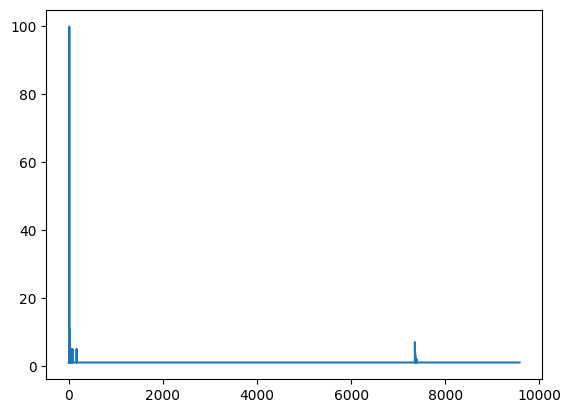

In [11]:
# descrete_duration = descritize_data(protocoll, 20)
# plt.plot(range(len(descrete_duration)), descrete_duration)
# print(np.unique(descrete_duration))
# plt.show()

# bin
discretized_packets = discretize_data(total_packets, 100)
plt.plot(range(len(discretized_packets)), discretized_packets)
print(np.unique(discretized_packets))

[1 2 3]


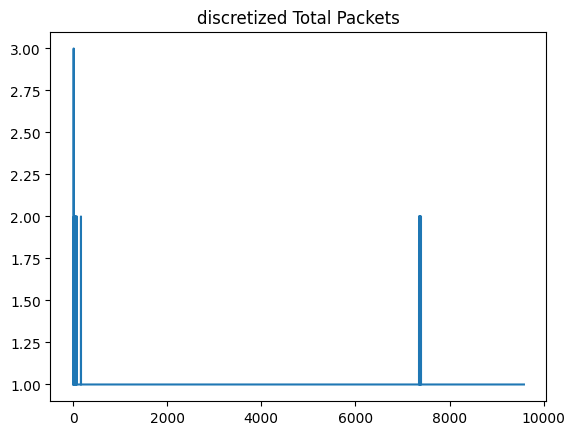

In [12]:
# descrete_duration = descritize_data(duration, type="percentile", percentiles=range(0, 100, 5))
# plt.plot(range(len(descrete_duration)), descrete_duration)
# plt.title("discretized Duration")
# print(np.unique(descrete_duration))
# plt.show()
# percentile
discretized_packets = discretize_data(total_packets, type="percentile", percentiles=[0, 70, 99])
plt.plot(range(len(discretized_packets)), discretized_packets)
plt.title("discretized Total Packets")
print(np.unique(discretized_packets))
plt.show()

# descrete_packets = descritize_data(np.array(total_packets).reshape(-1, 1) , num_bins=10, type="SAX")
# descrete_packets = np.array(descrete_packets)
# plt.plot(range(len(descrete_packets)), descrete_packets)
# plt.title("discretized Total Packets")
# print(np.unique(descrete_packets))
# plt.show()

# np.set_printoptions(suppress=True)
# np.percentile(np.unique(sorted(total_packets)), range(0, 100, 1))

In [13]:
data["Proto"].unique()

array(['tcp', 'udp', 'arp', 'icmp'], dtype=object)

In [14]:
def encode_feature_pair(data):
    def attribute_encoding(netflow, M_len):
        features = ['TotPkts','Proto']
        k = len(features)

        spaceSize = M_len[0] * M_len[1]    
        code = 0
        for i in range(k):
            code += netflow[features[i]] *  spaceSize/M_len[i]
            spaceSize /= M_len[i]
        return code

    # discretize features: protocol and the number of packages to all data
    discretized_df = data.copy()

    from sklearn.preprocessing import LabelEncoder

    # Create an instance of LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the label encoder on the column with categorical values
    discretized_df['Proto'] = label_encoder.fit_transform(discretized_df['Proto'])
    discretized_df['TotPkts'] = discretize_data(discretized_df['TotPkts'], type="percentile", percentiles=[0, 70, 99])

    M_len = [len(np.unique(discretized_df.loc[:, 'TotPkts'])), len(np.unique(discretized_df['Proto']))]
    #print("|M|:",M_len)

    discretized_df['encoded'] = discretized_df.apply(lambda row: attribute_encoding(row, M_len), axis=1).astype(int)

    #print(np.unique(discretized_df['encoded']), len(np.unique(discretized_df['encoded'])))
    return discretized_df
discretized_df = encode_feature_pair(data)

In [15]:
discretized_df

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,encoded
532,2011/08/18 10:19:15.693956,3587.569824,2,147.32.84.164,54784,<?>,74.125.232.215,443,PA_PA,0.0,0.0,2,978731,245317,normal,10
822,2011/08/18 10:19:18.143576,198.072739,2,147.32.84.164,56165,<?>,74.125.232.197,80,FA_FA,0.0,0.0,1,924,462,normal,6
842,2011/08/18 10:19:18.303590,197.928329,2,147.32.84.164,57965,<?>,209.85.149.138,80,FA_FA,0.0,0.0,1,924,462,normal,6
1021,2011/08/18 10:19:19.838272,0.000399,3,147.32.84.170,45807,<->,147.32.80.9,53,CON,0.0,0.0,1,400,74,normal,7
1022,2011/08/18 10:19:19.839123,0.000400,3,147.32.84.170,35380,<->,147.32.80.9,53,CON,0.0,0.0,1,400,74,normal,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1309670,2011/08/18 15:04:58.033603,0.000743,1,147.32.84.164,0x0008,<->,147.32.96.69,0x841e,ECO,0.0,0.0,1,196,98,normal,5
1309736,2011/08/18 15:04:59.032685,0.000913,1,147.32.84.164,0x0008,<->,147.32.96.69,0x841e,ECO,0.0,0.0,1,196,98,normal,5
1309782,2011/08/18 15:04:59.532629,0.000414,3,147.32.84.170,37138,<->,147.32.80.9,53,CON,0.0,0.0,1,244,81,normal,7
1309783,2011/08/18 15:04:59.533932,0.000322,3,147.32.84.170,39771,<->,147.32.80.9,53,CON,0.0,0.0,1,280,81,normal,7


### 1c. Answers and explanation

- Based on the plots, the distributions of protocols differ significantly between regular and infected hosts. Notably, icmp protocol is only observed in infected hosts. Additionally, the number of packages for infected hosts tends to be much larger, with values exceeding 1000 or even 10000, while regular hosts typically have values around 100. Therefore, the most relevant features are 'Proto' and 'TotPkts'.

- In conclusion, if the protocol is icmp or the number of packages exceeds 1000, it is highly indicative of a host being infected.

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

In [115]:
def get_connection_profiles(discretized_df, num_connectios=10):
    # get all unique src -> dst connections sorted by number of rows
    unique_connections = discretized_df.groupby(["SrcAddr", "DstAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
    unique_connections = unique_connections[:num_connectios]
    src, dst = unique_connections["SrcAddr"].tolist(), unique_connections["DstAddr"].tolist()
    n_gram_size = 3

    # collect all unique ngrams for later use as rows in the count matrix
    unique_ngrams = set()
    for conn in zip(src, dst):
        conn_data = discretized_df[(discretized_df["SrcAddr"] == conn[0]) & (discretized_df["DstAddr"] == conn[1])]["encoded"].tolist()
        three_gram = [conn_data[i:i+n_gram_size] for i in range(len(conn_data)-n_gram_size)]
        for ngram in three_gram:
            unique_ngrams.add(str(ngram))    

    connections = []
    table = []
    # loop over all connections
    for conn in zip(src, dst):
        connections.append(str(conn))
        occurence = {k:0 for k in unique_ngrams}
        # get combined dicretized feature for current connection
        conn_data = discretized_df[(discretized_df["SrcAddr"] == conn[0]) & (discretized_df["DstAddr"] == conn[1])]["encoded"].tolist()
        # create three grams
        three_gram = [conn_data[i:i+n_gram_size] for i in range(len(conn_data)-n_gram_size)]
        # keep track of 3grams that occur
        for gram in three_gram:
            occurence[str(gram)] = 1
        table.append(occurence.values())

    # convert occurence table to dataframe
    connection_profiles = pd.DataFrame(table, columns=list(unique_ngrams), index=connections)
    return connection_profiles
connection_profiles = get_connection_profiles(discretized_df)

In [141]:
def create_signature_matrix(connection_profiles, num_hashes=5):
    def hash_func(x, params, p):
        return (params[0]*x+params[1]) % p

    # fix numpy seed
    np.random.seed(42)

    connection_profiles_tranpose = connection_profiles.T
    num_rows = len(connection_profiles_tranpose)

    # define params for hash functions
    hash_params = []
    for _ in range(num_hashes):
        hash_params.append(np.random.randint(0, num_rows, 2))

    # create slots for signature matrix
    slots = np.full((num_hashes, connection_profiles_tranpose.shape[1]), np.inf)

    # loop over all rows
    for i in range(connection_profiles_tranpose.shape[0]):
        row = connection_profiles_tranpose.iloc[i]
        # loop over all columns
        for j in range(len(row)):
            # if columns is 1 calculate all hashes and select minimum
            if row[j] == 1:
                for x, params in enumerate(hash_params):
                    slots[x][j] = min(slots[x][j], hash_func(i, params, num_rows))

    # convert 2d array to dataframe
    signature_matrix = pd.DataFrame(slots).astype(int)
    return signature_matrix
signature_matrix = create_signature_matrix(connection_profiles, 25)

In [40]:
def column_sim(a, b):
    intersection = sum(x and y for x, y in zip(a, b))
    union = sum(x or y for x, y in zip(a, b))
    return intersection / union

def signature_sim(list1, list2):
    agree = np.sum(list1 == list2)
    return agree/len(list1)


In [91]:
num_buckets = 20
table = {k:[] for k in range(num_buckets)}
# loop over all signatures and bucket them 
for i in range(len(signature_matrix.columns)):
    band = "".join([str(x) for x in list(signature_matrix.iloc[:, i])])
    bucket = hash(band) % num_buckets
    bucket_list = table[bucket]
    bucket_list.append(i)
    table[bucket] = bucket_list

Text(0, 0.5, 'Difference')

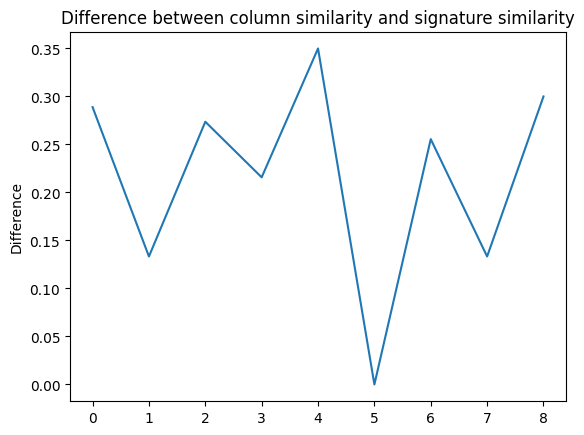

In [45]:
# Compare column similarity with signature similarity
similarity_difference = []
for i in range(len(connection_profiles)-1):
    #print("Column", column_sim(connection_profiles.iloc[i], connection_profiles.iloc[i+1]))
    #print("Signature", signature_sim(signature_matrix.iloc[:, i], signature_matrix.iloc[:, i+1]))
    #print("-"*25)
    similarity_difference.append(np.abs(column_sim(connection_profiles.iloc[i], connection_profiles.iloc[i+1]) - signature_sim(signature_matrix.iloc[:, i], signature_matrix.iloc[:, i+1])))
plt.plot(similarity_difference)
plt.title("Difference between column similarity and signature similarity")
plt.ylabel("Difference")

In [108]:
def find_nearest_neighbors(connection_profiles):
    nearest_neighbors = []
    # loop over all connections
    for i in range(len(connection_profiles)):
        # get candidate profile
        query_profile = connection_profiles.iloc[i]
        max_similarity = -1
        nearest_neighbor = None
        # loop over all connections and determine the closest neighbor using jaccard score
        for j in range(len(connection_profiles)):
            if i != j:
                similarity = jaccard_score(query_profile, connection_profiles.iloc[j])
                if similarity > max_similarity:
                    max_similarity = similarity
                    nearest_neighbor = j

        nearest_neighbors.append((i, nearest_neighbor))
    return nearest_neighbor

nearest_neighbors = find_nearest_neighbors(connection_profiles)
print("Nearest neighbors:", nearest_neighbors)

Nearest neighbors: 5


In [109]:
def calc_nearest_neighbors_lsh(signature_matrix):
    nearest_neighbors_lsh = []
    # loop over all signatures
    for i in range(len(signature_matrix.columns)):
        query_profile = signature_matrix.iloc[:, i]
        max_similarity = -1
        nearest_neighbor = None
        # determine the nearest neighbor
        for j in range(len(signature_matrix.columns)):
            if i != j:
                similarity = signature_sim(query_profile,  signature_matrix.iloc[:, j])
                if similarity > max_similarity:
                    max_similarity = similarity
                    nearest_neighbor = j

        nearest_neighbors_lsh.append((i, nearest_neighbor))
    return nearest_neighbors_lsh

nearest_neighbor = calc_nearest_neighbors_lsh(signature_matrix)
print("Nearest neighbors:", nearest_neighbor)

Nearest neighbors: [(0, 3), (1, 5), (2, 8), (3, 0), (4, 0), (5, 1), (6, 5), (7, 9), (8, 2), (9, 5)]


In [110]:
nearest_neighbors_lsh = calc_nearest_neighbors_lsh(signature_matrix)
percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh)[:, 1])/len(nearest_neighbors)
print(f"Percentage of true neighbors to signature neighbors: {percentage_true_neigbor*100}%")

Percentage of true neighbors to signature neighbors: 100.0%


In [113]:
def calc_nearest_neighbors_lsh_from_bucket(signature_matrix, num_buckets=10):
    table = {k:[] for k in range(num_buckets)}
    # loop over all signatures and bucket them 
    for i in range(len(signature_matrix.columns)):
        band = "".join([str(x) for x in list(signature_matrix.iloc[:, i])])
        bucket = hash(band) % num_buckets
        bucket_list = table[bucket]
        bucket_list.append(i)
        table[bucket] = bucket_list
        
    # calculate nearest neighbors from buckets
    nearest_neighbors_lsh = np.full(len(connection_profiles), -1)
    for bucket_idx, bucket in enumerate(table.values()):        
        if len(bucket) > 1:
            for i in range(len(bucket)):
                candidate = bucket[i]
                query_profile = signature_matrix.iloc[:, candidate]
                nearest_neighbor = 0
                max_sim = -1
                for j in range(len(bucket)):
                    if i != j:
                        sim = signature_sim(query_profile, signature_matrix.iloc[:, bucket[j]])
                        if sim > max_sim:
                            nearest_neighbor = bucket[j]
                            max_sim = sim
                nearest_neighbors_lsh[candidate] = nearest_neighbor
    return nearest_neighbors_lsh
nearest_neighbors_lsh = calc_nearest_neighbors_lsh_from_bucket(signature_matrix, 5)
percentage_true_neighbors = np.sum(np.array(nearest_neighbors)[:, 1] == nearest_neighbors_lsh)/len(nearest_neighbors_lsh)
print(f"Percentage of true neighbors to signature neighbors from Buckets: {percentage_true_neighbors*100}%")

Percentage of true neighbors to signature neighbors from Buckets: 20.0%


Text(0.5, 1.0, 'True neigbors percentage for bucket comparison')

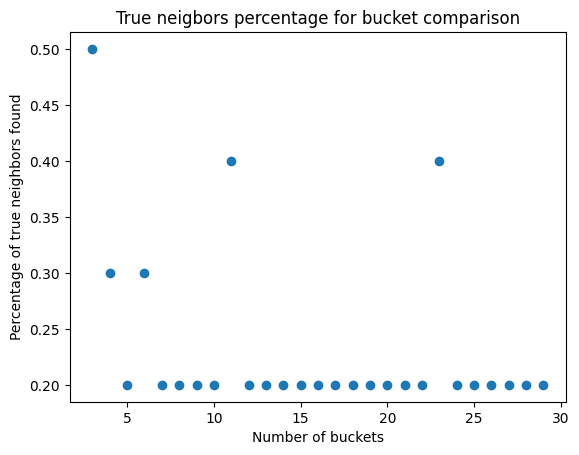

In [142]:
buckets = np.arange(3, 30, 1)
percentages = []
# create signature matrix with different number of bins
signature_matrix = create_signature_matrix(connection_profiles, num_hashes=100)
# loop over bucket values
for bucket in buckets:
    # find nearest neighbor for each signature
    nearest_neighbors_lsh = calc_nearest_neighbors_lsh_from_bucket(signature_matrix, num_buckets=bucket)
    # calculate percentage of neighbors that are the same as the true neighbors
    percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh))/len(nearest_neighbors)
    percentages.append(percentage_true_neigbor)

# plot the bins and percentage of true neighbours found
plt.plot(buckets, percentages, 'o')
plt.xlabel("Number of buckets")
plt.ylabel("Percentage of true neighbors found")
plt.title("True neigbors percentage for bucket comparison")

# Overall calculating the nearest neighbors from the hash buckets seems to only result in a rate of 60%. When using 3 buckets. 

### 3b. Analysis and answers to the questions

Text(0.5, 1.0, 'True neigbors for pairwise comparison')

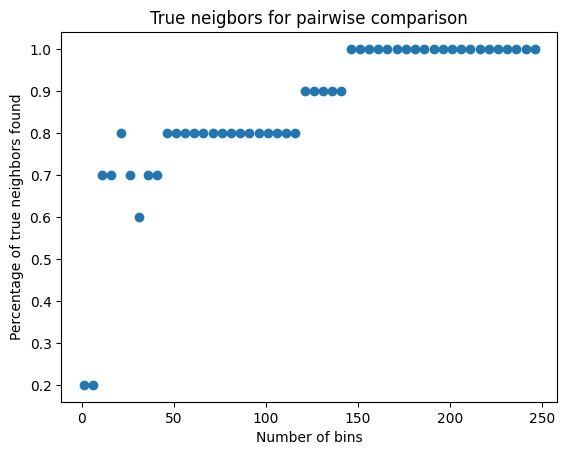

In [140]:
connection_profiles = get_connection_profiles(discretized_df, 10)
num_bins = np.arange(1, 250, 5)
percentages = []
# loop over bin values
for bin in num_bins:
    # create signature matrix with different number of bins
    signature_matrix = create_signature_matrix(connection_profiles, num_hashes=bin)
    # find nearest neighbor for each signature
    nearest_neighbors_lsh = calc_nearest_neighbors_lsh(signature_matrix)
    # calculate percentage of neighbors that are the same as the true neighbors
    percentage_true_neigbor = np.sum(np.array(nearest_neighbors)[:, 1] == np.array(nearest_neighbors_lsh)[:, 1])/len(nearest_neighbors)
    percentages.append(percentage_true_neigbor)

# plot the bins and percentage of true neighbours found
plt.plot(num_bins, percentages, 'o')
plt.xlabel("Number of bins")
plt.ylabel("Percentage of true neighbors found")
plt.title("True neigbors for pairwise comparison")

The performance of finding nearest neighbors with LSH increases if we increase the number of hashes used. This is likely because
using more hashes results in a better approximations of the jaccard score. 

In [151]:
num_connections = [10, 25, 50, 10, 20, 30]
connection_profiles = get_connection_profiles(discretized_df, 200)

In [152]:
times = []
sizes = []
for n in num_connections:
    connection_profiles = get_connection_profiles(discretized_df, n)
    start_time = time.time()
    find_nearest_neighbors(connection_profiles)
    end_time = time.time()
    elapsed_time_classic = end_time - start_time
    print(f"Finding nearest neighbors({n}) using Jaccard Score:")
    print(f"Elapsed time: {elapsed_time_classic} seconds")
    bytes_classic = connection_profiles.iloc[0][0].itemsize * connection_profiles.shape[0] * connection_profiles.shape[1]
    times.append(elapsed_time_classic)
    sizes.append(bytes_classic)

Finding nearest neighbors using Jaccard Score:
Elapsed time: 0.2099628448486328 seconds
Finding nearest neighbors using Jaccard Score:
Elapsed time: 0.9983043670654297 seconds
Finding nearest neighbors using Jaccard Score:
Elapsed time: 4.556672811508179 seconds
Finding nearest neighbors using Jaccard Score:
Elapsed time: 0.16326403617858887 seconds
Finding nearest neighbors using Jaccard Score:
Elapsed time: 0.5982198715209961 seconds
Finding nearest neighbors using Jaccard Score:
Elapsed time: 1.5055794715881348 seconds


In [ ]:
times_lsh = []
sizes_lsh = []
for n in num_connections:
    connection_profiles = get_connection_profiles(discretized_df, n)
    start_time = time.time()
    signature_matrix = create_signature_matrix(connection_profiles, 100)
    calc_nearest_neighbors_lsh(signature_matrix)
    end_time = time.time()
    elapsed_time_lsh = end_time - start_time
    print(f"Finding nearest neighbors({n}) using LSH:")
    print(f"Elapsed time: {elapsed_time_lsh} seconds")
    bytes_lsh = signature_matrix.iloc[0][0].itemsize * signature_matrix.shape[0] * signature_matrix.shape[1]
    times_lsh.append(elapsed_time_lsh)
    sizes_lsh.append(bytes_lsh)

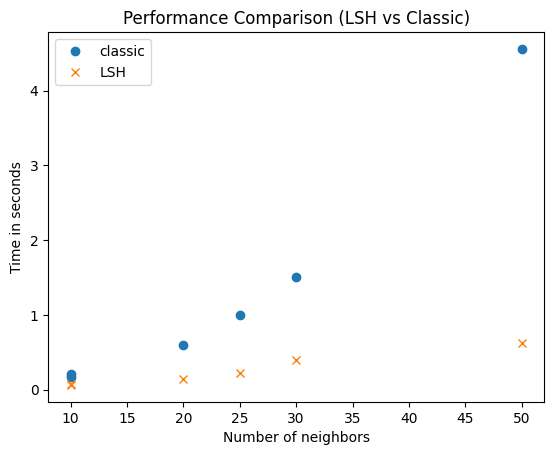

In [173]:
plt.plot(num_connections, times, 'o', label="classic")
plt.plot(num_connections, times_lsh, 'x', label="LSH")
plt.title("Runtime Comparison (LSH vs Classic)")
plt.xlabel("Number of neighbors")
plt.ylabel("Time in seconds")
plt.legend()


## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

In [29]:
# create flexfringe object
flexfringe = FlexFringe(
    flexfringe_path=path_flexfringe,
    heuristic_name="alergia",
    data_name="alergia_data",
    slidingwindow=1, 
    swsize=15, 
    sinkson=1,
    sinkcount=100,
    printblue=1,
    markovian=1
    )
# get infected tracefile
infected_tracefile = discretized_df[discretized_df["SrcAddr"] == infected_host_ip].rename(columns={'encoded': 'symb'})

# create model from infected data
flexfringe.fit(infected_tracefile)

# showcase model
# flexfringe.show()

predict_df = flexfringe.predict(discretized_df[discretized_df["SrcAddr"] == infected_host_ip2].rename(columns={'encoded': 'symb'}))


In [30]:
def evaluate_szenario(discretized_df, return_profiles=False):
    hosts = discretized_df.groupby(["SrcAddr"]).size().reset_index().rename(columns={0:'count'}).sort_values(by="count", ascending=False)
    hosts = hosts[hosts["count"] > 1]

    # if infected_host_ip not in hosts["SrcAddr"].values:
    #     hosts = pd.concat([hosts, pd.DataFrame({"count": 0, "SrcAddr":infected_host_ip}, index=[0])], ignore_index=True)

    flexfringe = FlexFringe(
        flexfringe_path=path_flexfringe,
        heuristic_name="alergia",
        data_name="alergia_data",
        slidingwindow=1, 
        swsize=15, 
        sinkson=1,
        sinkcount=100,
        printblue=1,
        markovian=1
        )

    table = []

    for i, host in enumerate(hosts["SrcAddr"]):
        row = defaultdict()
        df = discretized_df[discretized_df["SrcAddr"] == host].rename(columns={'encoded': 'symb'})
        flexfringe.fit(df)

        with open(flexfringe.json_out, 'r') as json_file:
            model_json = json.load(json_file)
            nodes = model_json["nodes"]
            for node in nodes:
                if "trans_counts" not in node["data"].keys():
                    continue
                for symbol in node["data"]["trans_counts"]:
                    column = str(node['id'])+'-'+str(symbol)
                    row[column] = int(node["data"]["trans_counts"][symbol])

        table.append(row)

    unique_state_symbols = set()
    for row in table:
        for key in row.keys():
            unique_state_symbols.add(key)

    state_symbol_count_df = pd.DataFrame(np.zeros((len(hosts), len(unique_state_symbols))), columns=list(unique_state_symbols), index=hosts["SrcAddr"].values)
    for i in range(len(hosts)):
        state_symbol_count_df.iloc[i] = [table[i].get(x, 0) for x in unique_state_symbols]

    state_symbol_count_df = state_symbol_count_df.astype(int)
    if return_profiles:
        return state_symbol_count_df

    # compute distances to other hosts
    infected_profile = state_symbol_count_df.loc[infected_host_ip].values.reshape(1, -1)
    threshold = 0.005
    count = 0
    tp, tn, fp, fn = 0, 0, 0, 0

    for i in range(len(hosts)):
        distance = cosine_similarity(infected_profile, state_symbol_count_df.iloc[i].values.reshape(1, -1))[0]
        pred_label = "botnet" if distance > threshold else "normal"
        label = discretized_df[discretized_df["SrcAddr"] == hosts.iloc[i]["SrcAddr"]]["Label"].iloc[0]

        if pred_label == label:
            count += 1

        if label == "botnet" and pred_label == "botnet":
            tp += 1
        elif label == "botnet" and pred_label == "normal":
            fp += 1
        elif label == "normal" and pred_label == "normal":
            tn += 1
        elif label == "normal" and pred_label == "botnet":
            fn += 1

    if (tp+fn) > 0:
        recall = tp / (tp + fn)
    else: 
        recall = -1
    if (tp +fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = -1
    print(f"Accuracy:       {count/len(hosts)}")
    print(f"Precision:      {precision}")
    print(f"Recall:         {recall}\n")

    print(f"False Positive: {fp}")
    print(f"False Negative: {fn}")
    print(f"True Positive:  {tp}")
    print(f"True Negative:  {tn}")
    

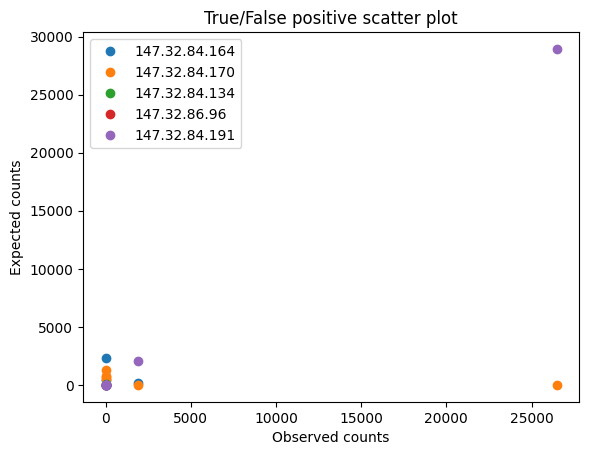

In [148]:
expected_count_df = evaluate_szenario(discretized_df[discretized_df["SrcAddr"] == infected_host_ip], return_profiles=True)
ips = list(discretized_df["SrcAddr"].unique()[:4]) + [infected_host_ip2]
for ip in ips:
    observed_count_df = evaluate_szenario(discretized_df[discretized_df["SrcAddr"] == ip], return_profiles=True)
    state_intersect = list(set(expected_count_df.columns).intersection(set(observed_count_df)))
    plt.plot(expected_count_df[state_intersect].iloc[0], observed_count_df[state_intersect].iloc[0],'o', label=ip)

plt.legend()
plt.title("True/False positive scatter plot")
plt.xlabel("Observed counts")
plt.ylabel("Expected counts")
plt.show()

In [149]:
# calculate statistics on all szenarios
szenario_data = [data_9, data, data_11, data_12]
for data, szenario in zip(szenario_data, range(9, 13)):
    print("-"*12+"Szenario: "+str(szenario)+"-"*12)
    processed = preprocess_data(data)
    discretized_data = encode_feature_pair(processed)
    evaluate_szenario(discretized_data)
    print("-"*25)

------------Szenario:9------------
Accuracy:       0.4
Precision:      1.0
Recall:         0.35714285714285715

False Positive: 0
False Negative: 18
True Positive:  10
True Negative:  2
-------------------------
------------Szenario:10------------
Accuracy:       0.47368421052631576
Precision:      1.0
Recall:         0.47368421052631576

False Positive: 0
False Negative: 10
True Positive:  9
True Negative:  0
-------------------------
------------Szenario:11------------
Accuracy:       0.7142857142857143
Precision:      0.6666666666666666
Recall:         0.6666666666666666

False Positive: 1
False Negative: 1
True Positive:  2
True Negative:  3
-------------------------
------------Szenario:12------------
Accuracy:       0.47368421052631576
Precision:      1.0
Recall:         0.47368421052631576

False Positive: 0
False Negative: 10
True Positive:  9
True Negative:  0
-------------------------


### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.